### Basic Application Requirements

In [2]:
# Import necessary models
import pandas as pd
import matplotlib.pyplot as plt
import pyspark
import seaborn as sns
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions as pyspark_functions
from pyspark import SparkContext, SparkConf

In [3]:
# Creating spark instance
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

In [4]:
# Reading the dataset
col_mat_nuw_data = spark.read.csv("Datasets/col_mat_nuw_output.csv", header=None, inferSchema=True)

### Basic Details of the Dataset

In [5]:
# Data Schema
col_mat_nuw_data.printSchema()

root
 |-- _c0: double (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: date (nullable = true)
 |-- _c3: date (nullable = true)



In [6]:
# Basic overview of the dataset
col_mat_nuw_data.show()

+--------------------+--------------+----------+----------+
|                 _c0|           _c1|       _c2|       _c3|
+--------------------+--------------+----------+----------+
|1.969834395781014...|Colombo Proper|2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|2019-01-12|2019-01-13|
|                NULL|Colombo Proper|2019-01-13|2019-01-14|
|1.336291906862603...|Colombo Proper|201

#### Rename Column Names

In [7]:
# Define the new column names
column_names = ['HCHO Reading', 'Location', 'Current Date', 'Next Date']

# Rename the columns
for item, col_name in enumerate(column_names):
    col_mat_nuw_data = col_mat_nuw_data.withColumnRenamed(col_mat_nuw_data.columns[item], col_name)

In [8]:
# Dataset with column names
col_mat_nuw_data.show()

+--------------------+--------------+------------+----------+
|        HCHO Reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|1.969834395781014...|Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|  2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|1.33629

#### Basic Preprocessing

##### Finding the null/missing values of the dataset.

In [9]:
# Finding the null values
# Checking the sum of the Null values
col_mat_nuw_data.select(*[pyspark_functions.sum(pyspark_functions.col(c).isNull().cast("int")).alias(c) for c in col_mat_nuw_data.columns]).show()


+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|        2419|       0|           0|        0|
+------------+--------+------------+---------+



Basic plot of the HCHO Reading Distribution

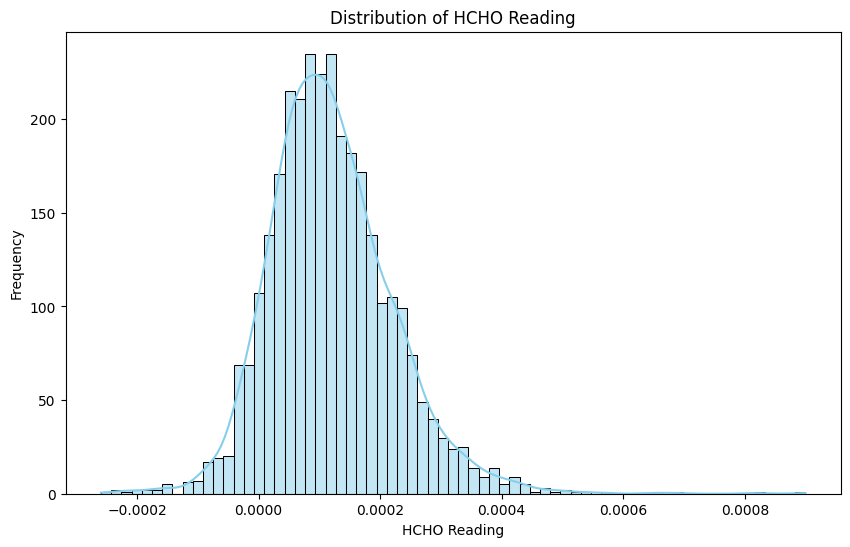

In [10]:
hcho_dataframe = col_mat_nuw_data.select("HCHO Reading").toPandas()

# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(hcho_dataframe["HCHO Reading"], kde=True, color='skyblue')
plt.title('Distribution of HCHO Reading')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.show()

There are 2419 Missing/Null values in the dataset. Therefore let's remove them and If we take a look at the distribution This distribution takes a normal distribution. Therefore let's replace the missing values within the Last observation carried forward (LOCF) and Next Observation Carried Backwards (NOCB) Methods.

In [29]:
# Writing the dataset back to again csv after pre-processing
pandas_df = col_mat_nuw_data.toPandas()
pandas_df.to_csv('Datasets/Pre-Processed_col_mat_nuw_output.csv')